C:\Users\Jupiter\AppData\Local\Temp\ipykernel_23576\1085831149.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, parse_dates=['date'])
[I 2025-02-03 22:47:14,771] A new study created in memory with name: no-name-0d0b9cf7-4bd6-4b19-9b75-89ed7992589a
[I 2025-02-03 22:47:16,122] Trial 0 finished with value: 0.3123692279069105 and parameters: {'lags': 7, 'n_estimators': 275, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3123692279069105.
[I 2025-02-03 22:47:17,285] Trial 1 finished with value: 0.30590013144048 and parameters: {'lags': 3, 'n_estimators': 281, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.30590013144048.
[I 2025-02-03 22:47:17,615] Trial 2 finished with value: 0.31555246884279264 and pa

Best trial:
  lags: 4
  n_estimators: 242
  max_depth: 3
  min_samples_split: 9
  min_samples_leaf: 5
  max_features: log2
  Best CV RMSE: 0.3039


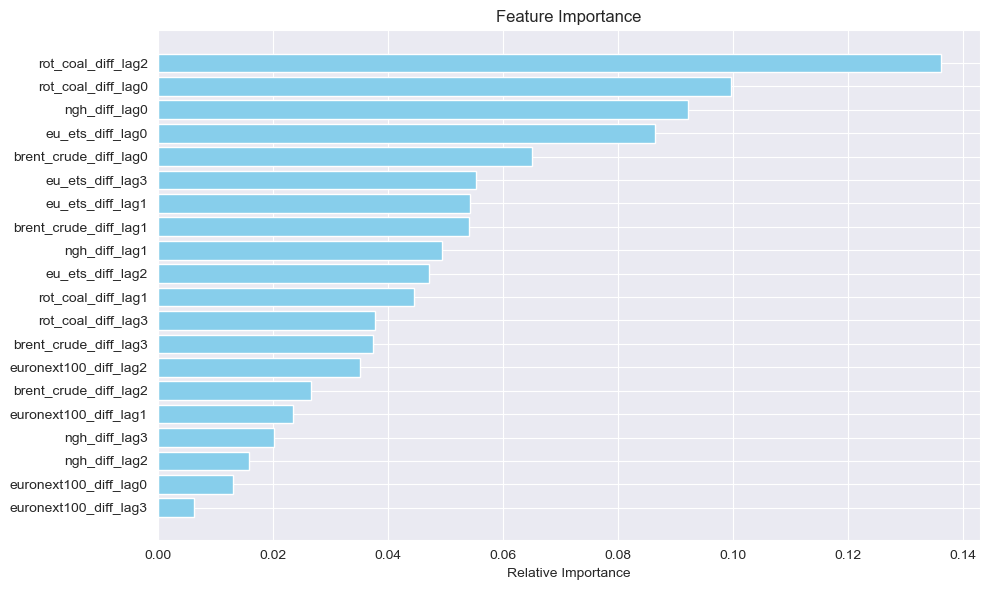


Test Set Performance (Level Forecasts):
  MAE: 1.1570
  RMSE: 1.6975
  R2 Score: 0.9950


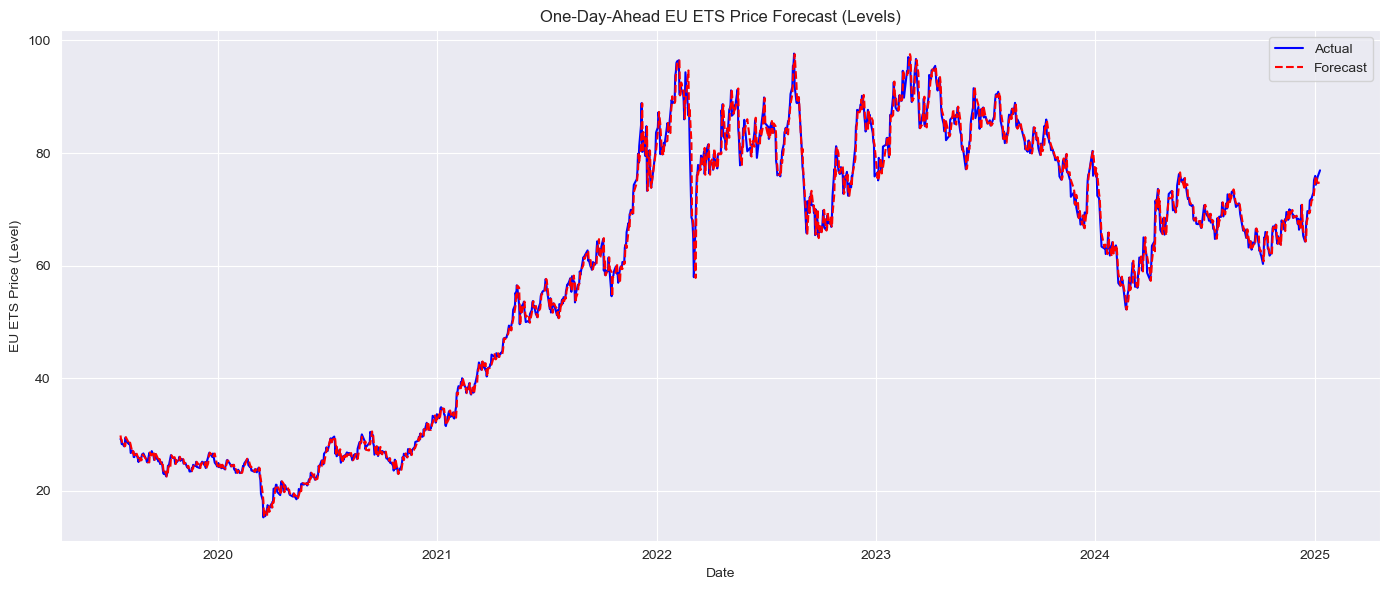

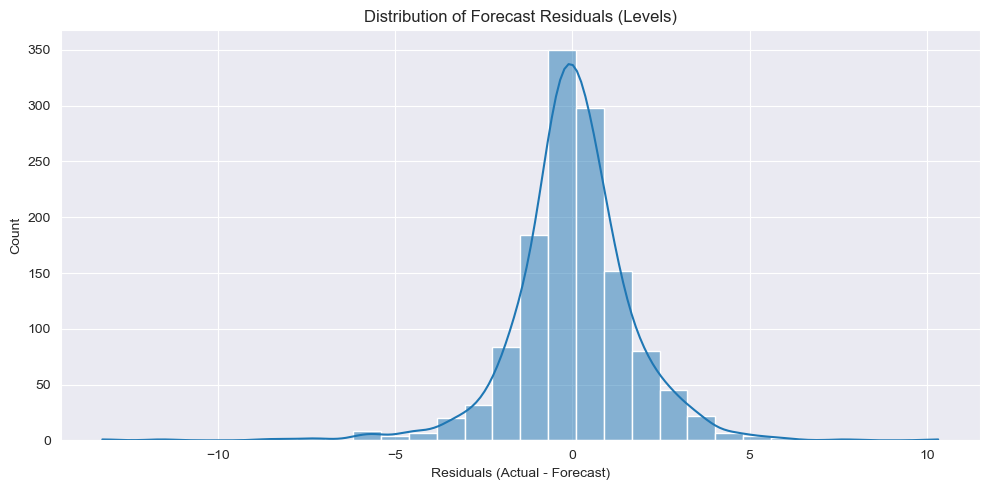

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# For reproducibility
RANDOM_STATE = 42

def load_and_prepare_data(file_path):
    """
    Loads the CSV file, parses dates, sorts by date, and creates differenced columns.
    The original 'eu_ets' values are stored in 'eu_ets_level' for forecast reconstruction.
    For every column except 'date' and 'eu_ets_level', a differenced column is created.
    The target is defined as the next day's difference of EU ETS.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Save original EU ETS levels for later forecast reconstruction
    df['eu_ets_level'] = df['eu_ets']

    # Identify columns to difference (all except 'date' and 'eu_ets_level')
    cols_to_diff = [col for col in df.columns if col not in ['date', 'eu_ets_level']]
    for col in cols_to_diff:
        diff_col = col + '_diff'
        df[diff_col] = df[col] - df[col].shift(1)

    # Define the target: next day's difference of EU ETS
    df['target'] = df['eu_ets_diff'].shift(-1)

    # Drop rows with NaN values from differencing and shifting
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def create_lag_features(df, n_lags):
    """
    For each differenced column (except the target), create lag features.
    For a given column, this produces features:
      - lag 0: the current day's value
      - lag 1: the previous day's value, etc.
    The target remains the next day's eu_ets_diff.
    """
    features = pd.DataFrame(index=df.index)
    # Identify all differenced columns except the target
    diff_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']

    for col in diff_cols:
        for lag in range(n_lags):
            features[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Target is the next day's eu_ets_diff value
    target = df['eu_ets_diff'].shift(-1)

    # Combine features and target; drop rows with missing values due to shifting
    combined = pd.concat([features, target.rename('target')], axis=1).dropna()
    X = combined.drop('target', axis=1)
    y = combined['target']
    return X, y

def objective(trial, df_train):
    """
    Optuna objective function that tunes both Random Forest hyperparameters and the number of lags.

    Steps:
      1. Suggests a number of lags to create lagged features.
      2. Builds a feature matrix X and target y.
      3. Standardizes X.
      4. Tunes Random Forest parameters and evaluates the model using time-series cross-validation.
    """
    # Suggest the number of lags (for example, between 1 and 10)
    n_lags = trial.suggest_int("lags", 1, 10)

    # Create lagged features from training data
    X, y = create_lag_features(df_train, n_lags)

    # Convert to numpy arrays
    X_np = X.values
    y_np = y.values

    # Additional Random Forest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_np):
        X_tr, X_val = X_np[train_index], X_np[val_index]
        y_tr, y_val = y_np[train_index], y_np[val_index]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        model = RandomForestRegressor(**params)
        model.fit(X_tr_scaled, y_tr)
        y_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def main():
    # 1. Load and prepare the data
    file_path = 'data/189_clean_data_v3.csv'  # Update this to your actual file path
    df = load_and_prepare_data(file_path)

    # For forecast reconstruction, keep original EU ETS levels and dates
    original_info = df[['date', 'eu_ets_level']].copy()

    # 2. Create a chronological train-test split (80/20 split)
    split_index = int(len(df) * 0.7)
    df_train = df.iloc[:split_index].reset_index(drop=True)
    df_test = df.iloc[split_index:].reset_index(drop=True)

    # 3. Hyperparameter optimization with Optuna (including lag length)
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df_train), n_trials=50)

    print("Best trial:")
    best_trial = study.best_trial
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    print(f"  Best CV RMSE: {best_trial.value:.4f}")

    # 4. Train the final model on the entire training set using the best parameters
    best_n_lags = best_trial.params["lags"]
    X_train, y_train = create_lag_features(df_train, best_n_lags)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)

    final_model = RandomForestRegressor(
        n_estimators=best_trial.params["n_estimators"],
        max_depth=best_trial.params["max_depth"],
        min_samples_split=best_trial.params["min_samples_split"],
        min_samples_leaf=best_trial.params["min_samples_leaf"],
        max_features=best_trial.params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_model.fit(X_train_scaled, y_train.values)

    # --- Plot Relative Feature Importance ---
    feature_importances = final_model.feature_importances_
    feature_names = X_train.columns
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
    plt.xlabel("Relative Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    # 5. Forecast on the test set
    X_test, y_test = create_lag_features(df_test, best_n_lags)
    X_test_scaled = scaler.transform(X_test.values)
    y_pred_diff = final_model.predict(X_test_scaled)

    # Reconstruct level forecasts:
    # For each row in X_test, the target corresponds to day t+1's eu_ets_diff.
    # Add the predicted difference to the base level (eu_ets_level) from df_test.
    valid_indices = X_test.index  # indices that survived lag creation and dropping NA
    base_levels = df_test.loc[valid_indices, 'eu_ets_level'].values
    forecast_levels = base_levels + y_pred_diff

    # Actual levels: base level + actual diff (i.e., y_test)
    actual_levels = base_levels + y_test.values

    # 6. Evaluate forecasts
    mae = mean_absolute_error(actual_levels, forecast_levels)
    rmse = np.sqrt(mean_squared_error(actual_levels, forecast_levels))
    r2 = r2_score(actual_levels, forecast_levels)

    print("\nTest Set Performance (Level Forecasts):")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")

    # 7. Graphical evaluation of forecasts
    forecast_dates = df_test.loc[valid_indices, 'date']

    plt.figure(figsize=(14, 6))
    plt.plot(forecast_dates, actual_levels, label="Actual", color="blue")
    plt.plot(forecast_dates, forecast_levels, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("EU ETS Price (Level)")
    plt.title("One-Day-Ahead EU ETS Price Forecast (Levels)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    residuals = actual_levels - forecast_levels
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals (Actual - Forecast)")
    plt.title("Distribution of Forecast Residuals (Levels)")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
